In [3]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install "numpy<2"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from missing_generator import produce_missings

data = pd.read_csv("data_matrix.csv", sep=';')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [5]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
missing_percent = 0.2     # 10% missing
burst_length = 5          # for bursty missing, 

# 1. Generate a missing mask for all sensor columns (excluding 'date')
sensor_columns = [col for col in data.columns if col != 'date']
mask = pd.DataFrame(False, index=data.index, columns=sensor_columns)

# For each sensor, generate missing indices
for col in sensor_columns:
    _, masked_col = produce_missings(data[col], missing_percent, burst_length)
    mask[col] = masked_col.isna()

# 2. Apply the mask to create the data with NaNs
data_with_nans = data.copy()
data_with_nans[sensor_columns] = data_with_nans[sensor_columns].mask(mask)

# 3. (Optional) Save the mask for reproducibility
mask.to_csv('missing_mask.csv')

Polynomial Interpolation (degree 3)
  → RMSE: 16.2718
  → R²:   0.5058


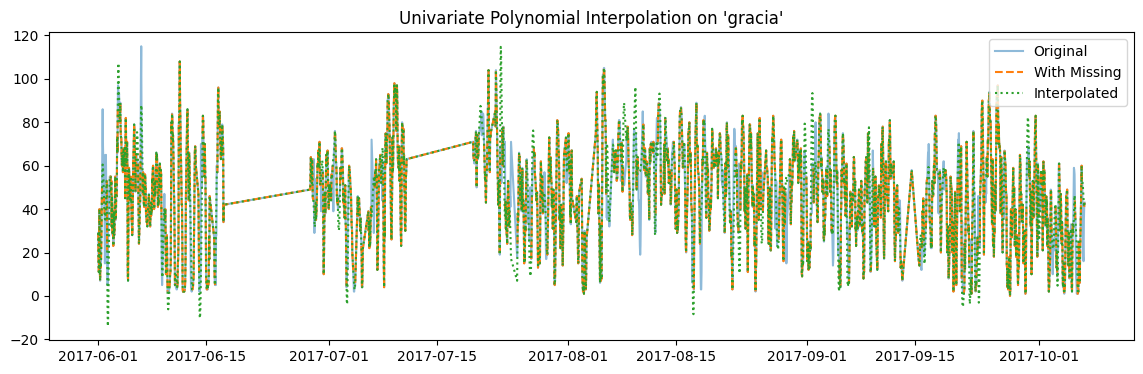

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
sensor_name = 'gracia' 

# Step 1: Keep a copy of the ground truth
original_series = data[sensor_name]
masked_series = data_with_nans[sensor_name]  

# Step 2: Apply polynomial interpolation
interpolated = masked_series.interpolate(method='polynomial', order=3)

# Step 3: Evaluate only at the missing indices
missing_indices = mask.index[mask[sensor_name]].to_numpy()
true_values     = original_series.loc[missing_indices]
imputed_values  = interpolated.loc[missing_indices]

# Step 4: Remove any residual NaNs before metric computation
valid_mask = np.isfinite(true_values.values) & np.isfinite(imputed_values.values)
true_values_clean = true_values.values[valid_mask]
imputed_values_clean = imputed_values.values[valid_mask]

# Step 5: Evaluation
rmse = np.sqrt(mean_squared_error(true_values_clean, imputed_values_clean))
r2   = r2_score(true_values_clean, imputed_values_clean)

print(f"Polynomial Interpolation (degree 3)")
print(f"  → RMSE: {rmse:.4f}")
print(f"  → R²:   {r2:.4f}")

# Step 6: Plot (optional)
plt.figure(figsize=(14,4))
plt.plot(original_series, label='Original', alpha=0.5)
plt.plot(masked_series, label='With Missing', linestyle='--')
plt.plot(interpolated, label='Interpolated', linestyle='dotted')
plt.title(f"Univariate Polynomial Interpolation on '{sensor_name}'")
plt.legend()
plt.show()



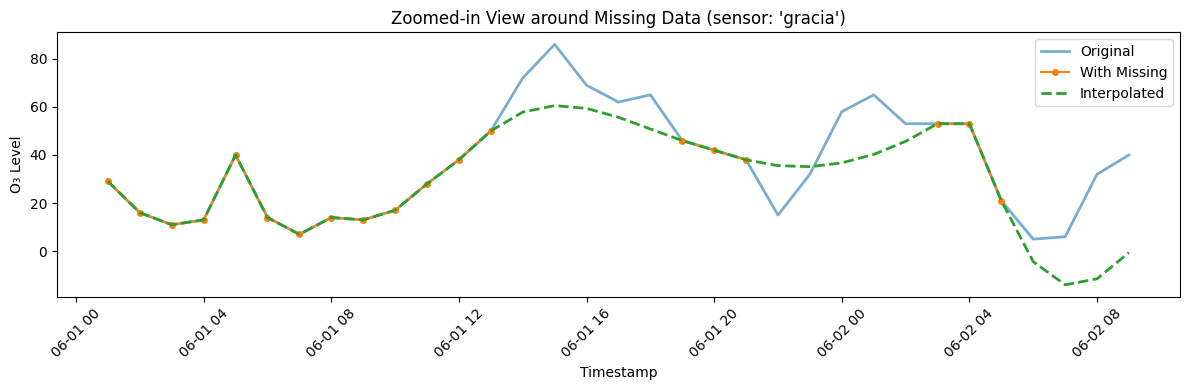

In [7]:
# Get the center timestamp of first missing value
center_timestamp = missing_indices[0]

# Convert timestamp to positional index
center_idx = original_series.index.get_loc(center_timestamp)

# Define zoom range around that index
window_size = 20  # ±20 time steps
start_idx = max(center_idx - window_size, 0)
end_idx   = min(center_idx + window_size, len(original_series))

# Get actual time range
time_range = original_series.index[start_idx:end_idx]

# Extract slices
original_slice     = original_series.loc[time_range]
masked_slice       = masked_series.loc[time_range]
interpolated_slice = interpolated.loc[time_range]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(original_slice,     label='Original',     linewidth=2, alpha=0.6)
plt.plot(masked_slice,       label='With Missing', marker='o', linestyle='-', markersize=4)
plt.plot(interpolated_slice, label='Interpolated', linestyle='--', linewidth=2)

plt.title(f"Zoomed-in View around Missing Data (sensor: '{sensor_name}')")
plt.xlabel("Timestamp")
plt.ylabel("O₃ Level")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
T = 6  # sequence length

sensor_series = data[sensor_name].copy()
masked_series = data_with_nans[sensor_name].copy()

# Step 1: Normalize the masked signal
scaler = MinMaxScaler()
scaled_series = pd.Series(
    scaler.fit_transform(masked_series.values.reshape(-1, 1)).flatten(),
    index=masked_series.index
)

# Step 2: Prepare clean sequences (T+1 points without NaNs)
# Add this debug code
def make_sequences(series, T):
    X, y = [], []
    vals = series.values
    skipped = 0
    for i in range(T, len(vals)):
        window = vals[i-T:i+1]
        if not np.any(np.isnan(window)):
            X.append(window[:-1])
            y.append(window[-1])
        else:
            skipped += 1
    print(f"Created {len(X)} sequences, skipped {skipped} due to NaNs")
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(scaled_series, T)

X_train, y_train = make_sequences(scaled_series, T)

# PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (N, T, 1)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)  # (N, 1)

# DataLoader
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

print(f"Number of training sequences: {len(X_train)}")
print(f"Training data shape: X_train {X_train.shape}, y_train {y_train.shape}")

# Check how many sequences you actually get
print(f"Original series length: {len(sensor_series)}")
print(f"Missing values: {masked_series.isna().sum()}")
print(f"Available values: {len(masked_series) - masked_series.isna().sum()}")


Created 1332 sequences, skipped 919 due to NaNs
Created 1332 sequences, skipped 919 due to NaNs
Number of training sequences: 1332
Training data shape: X_train (1332, 6), y_train (1332,)
Original series length: 2257
Missing values: 451
Available values: 1806


In [9]:
class LSTMImputer(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

model = LSTMImputer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_history = []

# Training
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_history.append(total_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.6f}")


Epoch 1/30, Loss: 1.930306
Epoch 10/30, Loss: 0.426357
Epoch 20/30, Loss: 0.418718
Epoch 30/30, Loss: 0.422872


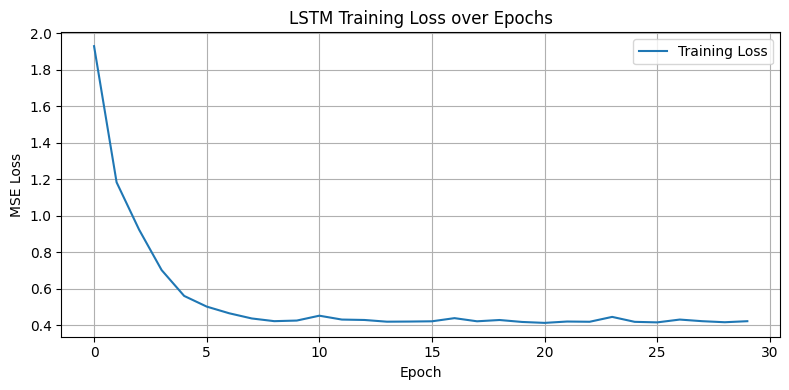

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model.eval()
reconstructed_scaled = scaled_series.values.copy()

# Add this debug code in your imputation loop
imputed_count = 0
skipped_count = 0

with torch.no_grad():
    for idx in sorted([original_series.index.get_loc(ts) for ts in missing_indices]):
        if idx < T:
            skipped_count += 1
            continue
        window = reconstructed_scaled[idx - T:idx]
        if np.any(np.isnan(window)):
            skipped_count += 1
            continue
        x_input = torch.tensor(window.reshape(1, T, 1), dtype=torch.float32)
        y_pred = model(x_input).item()
        reconstructed_scaled[idx] = y_pred
        imputed_count += 1

print(f"Imputed {imputed_count} values, skipped {skipped_count} values")

# Inverse transform
reconstructed_full = scaler.inverse_transform(reconstructed_scaled.reshape(-1, 1)).flatten()

# Gather imputed values
int_missing_idx = [original_series.index.get_loc(ts) for ts in missing_indices]
imputed_values_lstm = reconstructed_full[int_missing_idx]
true_values = original_series.values[int_missing_idx]


Imputed 451 values, skipped 0 values


LSTM Imputation Results:
  → RMSE: 17.2424
  → R²:   0.4451


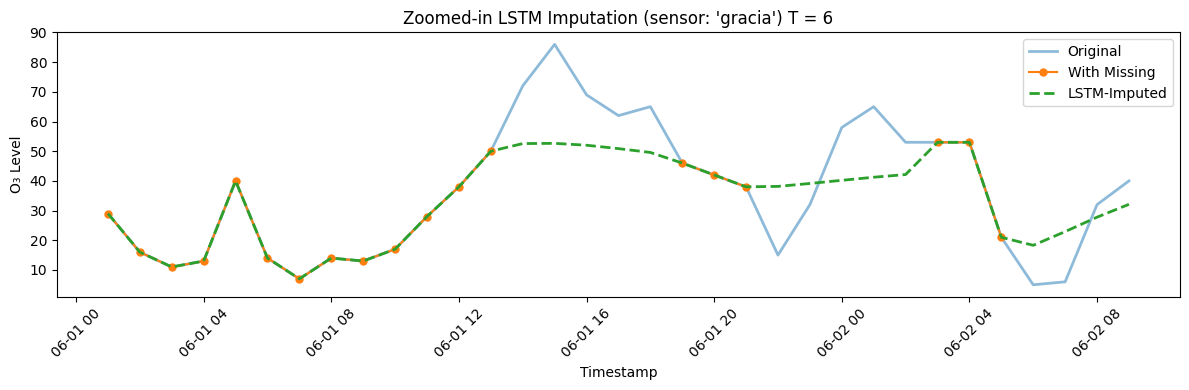

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Metrics
valid_idx = np.isfinite(true_values) & np.isfinite(imputed_values_lstm)
rmse_lstm = np.sqrt(mean_squared_error(true_values[valid_idx], imputed_values_lstm[valid_idx]))
r2_lstm   = r2_score(true_values[valid_idx], imputed_values_lstm[valid_idx])

print(f"LSTM Imputation Results:")
print(f"  → RMSE: {rmse_lstm:.4f}")
print(f"  → R²:   {r2_lstm:.4f}")

# Zoomed plot
center_idx = original_series.index.get_loc(missing_indices[0])
window_size = 20
start_idx = max(center_idx - window_size, 0)
end_idx = min(center_idx + window_size, len(original_series))

time_range = original_series.index[start_idx:end_idx]
lstm_series = pd.Series(reconstructed_full, index=original_series.index)

plt.figure(figsize=(12,4))
plt.plot(original_series.loc[time_range], label='Original', alpha=0.5, linewidth=2)
plt.plot(data_with_nans[sensor_name].loc[time_range], label='With Missing', linestyle='-', marker='o', markersize=5)
plt.plot(lstm_series.loc[time_range], '--', label='LSTM-Imputed', linewidth=2)
plt.title(f"Zoomed-in LSTM Imputation (sensor: '{sensor_name}') T = {T}")
plt.xlabel("Timestamp")
plt.ylabel("O₃ Level")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# Choose 3 sensors to analyze (missing values already generated in mask/data_with_nans)
target_sensors = ['gracia', 'eixample', 'hebron', 'prat', 'montcada', 'ciutadella', 'badalona', 'pr']

# Create a DataFrame with only the selected sensors and their missing values
data_multi = data_with_nans[target_sensors].copy()

# Get missing indices for each sensor from the mask
missing_indices_dict = {
    sensor: mask.index[mask[sensor]].to_list()
    for sensor in target_sensors
}

In [31]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Step 1: Use only sensor columns that exist in data_multi
valid_sensor_columns = [col for col in data.columns if col in data_multi.columns]

# Step 2: Extract numeric data (only existing sensors)
data_numeric = data_multi[valid_sensor_columns]

# Step 3: Store ground truth for those sensors
ground_truth = data[valid_sensor_columns].copy()

# Step 4: Initialize MICE imputer
mice_reg = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Step 5: Apply MICE imputation
imputed_array = mice_reg.fit_transform(data_numeric)
imputed_df = pd.DataFrame(imputed_array, columns=valid_sensor_columns, index=data.index)



/Users/ezgisenakarabacak/UPC/TOML/HW4/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [32]:
# Evaluate MICE predictions at known missing indices
from collections import defaultdict

results_mice = defaultdict(dict)

ground_truth = ground_truth.reset_index(drop=True)
imputed_df   = imputed_df.reset_index(drop=True)

for sensor in target_sensors:
    # Get missing timestamps for this sensor
    missing_times = missing_indices_dict[sensor]

    # Convert to integer positions
    missing_idx = [data.index.get_loc(ts) for ts in missing_times]

    # Extract values
    y_true = ground_truth.loc[missing_idx, sensor].values
    y_pred = imputed_df.loc[missing_idx, sensor].values

    # Clean pairs: remove any residual NaNs (edge case)
    valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    results_mice[sensor]['RMSE'] = rmse
    results_mice[sensor]['R2'] = r2

    # Print result
    print(f"MICE Linear Regression – {sensor}")
    print(f"  → RMSE: {rmse:.4f}")
    print(f"  → R²:   {r2:.4f}\n")


MICE Linear Regression – gracia
  → RMSE: 9.7761
  → R²:   0.8216

MICE Linear Regression – eixample
  → RMSE: 9.6377
  → R²:   0.8062

MICE Linear Regression – hebron
  → RMSE: 10.6330
  → R²:   0.8377

MICE Linear Regression – prat
  → RMSE: 14.6428
  → R²:   0.7638

MICE Linear Regression – montcada
  → RMSE: 10.8283
  → R²:   0.8871

MICE Linear Regression – ciutadella
  → RMSE: 16.7431
  → R²:   0.5558

MICE Linear Regression – badalona
  → RMSE: 12.7216
  → R²:   0.8011

MICE Linear Regression – pr
  → RMSE: 11.7005
  → R²:   0.7850



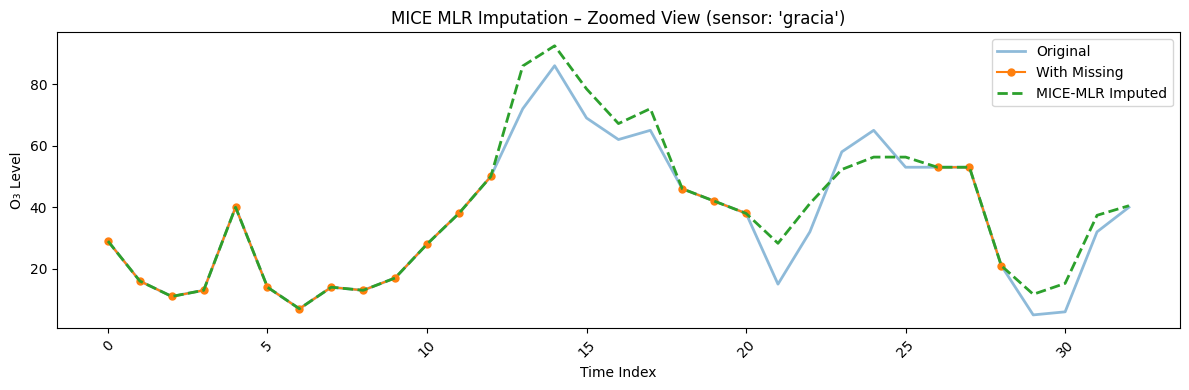

In [33]:
import matplotlib.pyplot as plt

# Choose one sensor to visualize
sensor_to_plot = 'gracia'
missing_times = missing_indices_dict[sensor_to_plot]

# Get integer position of the center of the first missing burst
center_time = missing_times[0]
center_idx = data.index.get_loc(center_time)

window_size = 20
start_idx = max(center_idx - window_size, 0)
end_idx   = min(center_idx + window_size, len(data))

# Prepare slices
time_range = ground_truth.index[start_idx:end_idx]
original_slice = ground_truth[sensor_to_plot].iloc[start_idx:end_idx]
masked_slice   = data_multi[sensor_to_plot].iloc[start_idx:end_idx]
mice_slice     = imputed_df[sensor_to_plot].iloc[start_idx:end_idx]

# Plot
plt.figure(figsize=(12,4))
plt.plot(original_slice.values, label='Original', alpha=0.5, linewidth=2)
plt.plot(masked_slice.values, label='With Missing', linestyle='-', marker='o', markersize=5)
plt.plot(mice_slice.values, '--', label='MICE-MLR Imputed', linewidth=2)

plt.title(f"MICE MLR Imputation – Zoomed View (sensor: '{sensor_to_plot}')")
plt.xlabel("Time Index")
plt.ylabel("O₃ Level")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

# Step 1: Create a new MICE imputer using KNN
mice_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5),
                            max_iter=10, random_state=0)

# Step 2: Fit and transform
imputed_knn_array = mice_knn.fit_transform(data_numeric)

# Preserve datetime index from data_numeric (same as data_multi)
imputed_knn_df = pd.DataFrame(imputed_knn_array, 
                              columns=data_numeric.columns,
                              index=data_numeric.index)  

# When you define ground_truth (or right after loading)
ground_truth.index = data_multi.index.copy()




/Users/ezgisenakarabacak/UPC/TOML/HW4/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [35]:
results_knn = defaultdict(dict)
# Ensure ground_truth index matches data_multi index (datetime)
ground_truth.index = data_multi.index.copy()

for sensor in target_sensors:
    missing_idx = missing_indices_dict[sensor]
    y_true = ground_truth.loc[missing_idx, sensor]
    y_pred = imputed_knn_df.loc[missing_idx, sensor]

    valid = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[valid], y_pred[valid]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    results_knn[sensor]['RMSE'] = rmse
    results_knn[sensor]['R2'] = r2

    print(f"MICE KNN – {sensor}")
    print(f"  → RMSE: {rmse:.4f}")
    print(f"  → R²:   {r2:.4f}")
    print()


MICE KNN – gracia
  → RMSE: 10.8623
  → R²:   0.7798

MICE KNN – eixample
  → RMSE: 10.4319
  → R²:   0.7730

MICE KNN – hebron
  → RMSE: 12.4274
  → R²:   0.7783

MICE KNN – prat
  → RMSE: 15.7812
  → R²:   0.7256

MICE KNN – montcada
  → RMSE: 11.6113
  → R²:   0.8702

MICE KNN – ciutadella
  → RMSE: 15.9948
  → R²:   0.5946

MICE KNN – badalona
  → RMSE: 13.4478
  → R²:   0.7777

MICE KNN – pr
  → RMSE: 12.8479
  → R²:   0.7407



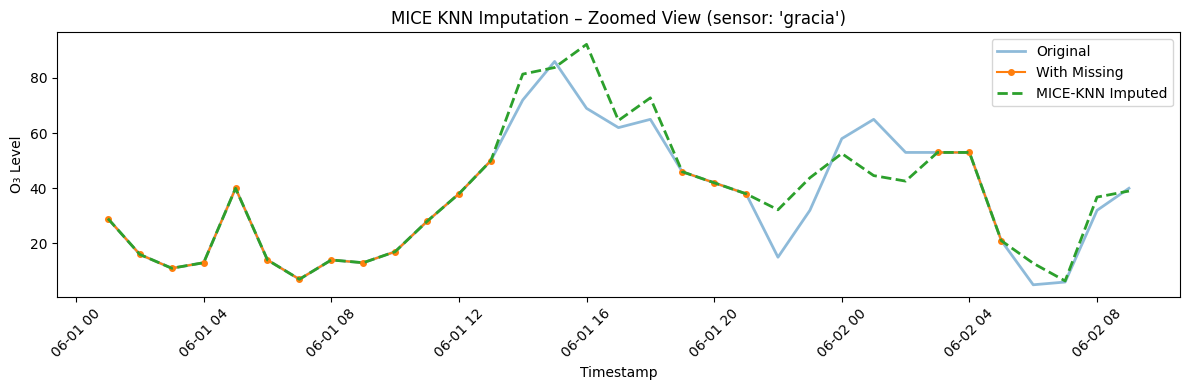

In [36]:
import matplotlib.pyplot as plt

# Choose sensor
sensor_to_plot = 'gracia'
missing_ts     = missing_indices_dict[sensor_to_plot]
center_ts      = missing_ts[0]  # Timestamp

# Find integer index of the timestamp in ground_truth
center_idx = ground_truth.index.get_indexer_for([center_ts])[0]

# Window bounds
window_size = 20
start_idx = max(center_idx - window_size, 0)
end_idx   = min(center_idx + window_size, len(ground_truth))

# Time axis (just for plotting)
time_range = ground_truth.index[start_idx:end_idx]

# Data slices
original_slice = ground_truth[sensor_to_plot].iloc[start_idx:end_idx]
masked_slice   = data_multi[sensor_to_plot].iloc[start_idx:end_idx]     # ← use iloc
knn_slice      = imputed_knn_df[sensor_to_plot].iloc[start_idx:end_idx] # ← also has RangeIndex

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_range, original_slice.values, label='Original', alpha=0.5, linewidth=2)
plt.plot(time_range, masked_slice.values, label='With Missing', linestyle='-', marker='o', markersize=4)
plt.plot(time_range, knn_slice.values, '--', label='MICE-KNN Imputed', linewidth=2)

plt.title(f"MICE KNN Imputation – Zoomed View (sensor: '{sensor_to_plot}')")
plt.xlabel("Timestamp")
plt.ylabel("O₃ Level")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
sensor_columns = ['gracia', 'eixample', 'hebron', 'prat', 'montcada', 'ciutadella', 'badalona', 'pr']
# Step 1: Initialize missing values with column mean
data_ae_init = data_multi[sensor_columns].copy()

# Fill NaNs with column means (used as placeholder for training)
data_ae_filled = data_ae_init.fillna(data_ae_init.mean())


In [55]:
import torch.optim as optim
# Step 2: Define Autoencoder (FIXED input_dim = 3)
class AE(nn.Module):
    def __init__(self, input_dim=8, latent_dim=2):  # ← changed from 8 to 3
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Initialize model
ae_model = AE(input_dim=8, latent_dim=2)  # explicitly pass input_dim=8criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.01)


In [56]:
# Convert to PyTorch tensor
data_tensor = torch.tensor(data_ae_filled.values, dtype=torch.float32)

# Mask to track originally missing values (1 if missing, 0 if observed)
missing_mask = data_ae_init.isna().values.astype(float)

n_epochs = 100

for epoch in range(n_epochs):
    ae_model.train()

    # Forward pass
    output = ae_model(data_tensor)

    # Compute loss using current reconstruction
    loss = criterion(output, data_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # After each epoch: replace only originally missing values
    with torch.no_grad():
    # Replace only missing entries using the reconstruction
        data_tensor = data_tensor * torch.tensor(1 - missing_mask, dtype=torch.float32) + \
                    output * torch.tensor(missing_mask, dtype=torch.float32)


    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs} – Loss: {loss.item():.6f}")


Epoch 1/100 – Loss: 3096.663574
Epoch 10/100 – Loss: 2450.829346
Epoch 20/100 – Loss: 918.802063
Epoch 30/100 – Loss: 280.730438
Epoch 40/100 – Loss: 225.664841
Epoch 50/100 – Loss: 172.222305
Epoch 60/100 – Loss: 145.048019
Epoch 70/100 – Loss: 133.881927
Epoch 80/100 – Loss: 128.495453
Epoch 90/100 – Loss: 126.041412
Epoch 100/100 – Loss: 124.774063


In [57]:
# Convert final imputed tensor to DataFrame
imputed_ae_df = pd.DataFrame(data_tensor.detach().cpu().tolist(), columns=sensor_columns, index=data_ae_init.index)

# Evaluate just like before
results_ae = defaultdict(dict)

for sensor in target_sensors:
    missing_idx = missing_indices_dict[sensor]

    y_true = ground_truth.loc[missing_idx, sensor].values
    y_pred = imputed_ae_df.loc[missing_idx, sensor].values

    valid = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[valid], y_pred[valid]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    results_ae[sensor]['RMSE'] = rmse
    results_ae[sensor]['R2'] = r2

    print(f"Autoencoder – {sensor}")
    print(f"  → RMSE: {rmse:.4f}")
    print(f"  → R²:   {r2:.4f}")
    print()


Autoencoder – gracia
  → RMSE: 12.8792
  → R²:   0.6904

Autoencoder – eixample
  → RMSE: 14.7342
  → R²:   0.5471

Autoencoder – hebron
  → RMSE: 12.6797
  → R²:   0.7692

Autoencoder – prat
  → RMSE: 16.9572
  → R²:   0.6832

Autoencoder – montcada
  → RMSE: 17.2360
  → R²:   0.7139

Autoencoder – ciutadella
  → RMSE: 17.8690
  → R²:   0.4940

Autoencoder – badalona
  → RMSE: 13.4018
  → R²:   0.7792

Autoencoder – pr
  → RMSE: 15.1452
  → R²:   0.6397



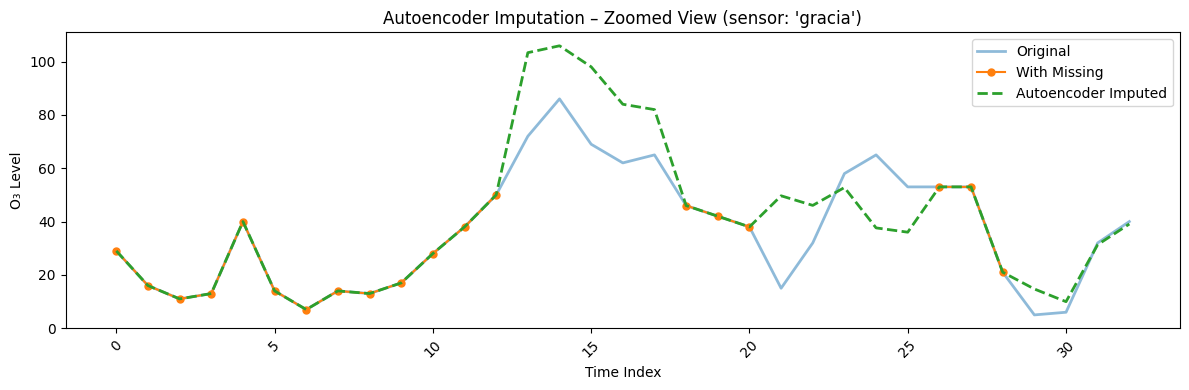

In [58]:
# Choose sensor to visualize
sensor_to_plot = 'gracia'  # or 'eixample', 'ciutadella'
missing_idx = missing_indices_dict[sensor_to_plot]

# Pick center of first missing burst
center_time = missing_idx[0]
center_idx = ground_truth.index.get_loc(center_time)
window_size = 20
start_idx = max(center_idx - window_size, 0)
end_idx = min(center_idx + window_size, len(data))

# Prepare data slices
time_range = ground_truth.index[start_idx:end_idx]
original_slice = ground_truth[sensor_to_plot].iloc[start_idx:end_idx]
masked_slice   = data_multi[sensor_to_plot].iloc[start_idx:end_idx]
ae_slice       = imputed_ae_df[sensor_to_plot].iloc[start_idx:end_idx]

# Plot
plt.figure(figsize=(12,4))
plt.plot(original_slice.values, label='Original', alpha=0.5, linewidth=2)
plt.plot(masked_slice.values, label='With Missing', linestyle='-', marker='o', markersize=5)
plt.plot(ae_slice.values, '--', label='Autoencoder Imputed', linewidth=2)

plt.title(f"Autoencoder Imputation – Zoomed View (sensor: '{sensor_to_plot}')")
plt.xlabel("Time Index")
plt.ylabel("O₃ Level")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
